In [9]:
library(ggplot2)
library(dplyr)
library(gplots)
library(reshape2)
library(ggpmisc)
library(ggpubr)
library(umap)
library(ggExtra) 
library(pals)
library(RColorBrewer)
library(ComplexHeatmap)
library(circlize)

library(heatmap.plus)

In [10]:
raw<-read.table(file="./Bioskryb_DNA_final_summary.txt",header=T)
variant_anno<-read.csv(file="../../variant_annotation/780_variant_annotation_by_all_samples.csv",header=T)

In [11]:
unique(raw$Mosaic_shared_btw_WGS_Amp)

[1] 1 0

In [12]:
raw$BINARY[raw$NORMAL_UPPER_CI>raw$LOWER_CI]<-0
raw$BINARY[raw$NORMAL_UPPER_CI<raw$LOWER_CI]<-1

In [13]:
length(((raw[raw$BINARY==1,]$CHROM.POS.REF.ALT)))

[1] 53919

In [276]:
blacklist<-read.table(file="../blacklist_variants.csv",header=F)
filtered2 <- subset(raw, BINARY %in% c(1) &
                   Mosaic_shared_btw_WGS_Amp==1 &
                   !(CHROM.POS.REF.ALT %in% blacklist$V1) & 
                   CHROM.POS.REF.ALT %in% variant_anno[variant_anno$R==1 
                                                       # (variant_anno$R==1 & variant_anno$IN_only==1) | (variant_anno$R==1 & variant_anno$CTX_BG_shared==1)
                                                       # (variant_anno$Right_only==1 & variant_anno$T==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$F==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$HIP==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$CTX_BG_shared==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$CTX_HIP_shared==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$HIP_BG_shard==1) 
                                                       ,]$variant_list &
                                                       PLATE %in% c("PL01","PL02"))

# MV recurrency calculation
recurrency<-data.frame(t(matrix(ncol=length(unique(filtered2$CHROM.POS.REF.ALT)))))
colnames(recurrency)<-"Recurrency"
recurrency$variant<-unique(filtered2$CHROM.POS.REF.ALT)
rownames(recurrency)<-unique(filtered2$CHROM.POS.REF.ALT)
for (i in unique(filtered2$CHROM.POS.REF.ALT)){
    recurrency[i,1]<-nrow(subset(filtered2, CHROM.POS.REF.ALT==i))
}

# filter out high AF MVs
filtered2<-subset(filtered2, CHROM.POS.REF.ALT %in% recurrency[recurrency$Recurrency<30 & recurrency$Recurrency>4,]$variant)

In [277]:
blacklist<-read.table(file="../blacklist_variants.csv",header=F)
filtered <- subset(raw, SAMPLE %in% filtered2$SAMPLE &
                   CHROM.POS.REF.ALT %in% filtered2$CHROM.POS.REF.ALT &
                   Mosaic_shared_btw_WGS_Amp==1 &
                   !(CHROM.POS.REF.ALT %in% blacklist$V1) & 
                   #CHROM.POS.REF.ALT %in% variant_anno[variant_anno$R==1,]$variant_list &
                   PLATE %in% c("PL01","PL02"))

In [278]:
# MV recurrency calculation
recurrency<-data.frame(t(matrix(ncol=length(unique(filtered$CHROM.POS.REF.ALT)))))
colnames(recurrency)<-"Recurrency"
recurrency$variant<-unique(filtered$CHROM.POS.REF.ALT)
rownames(recurrency)<-unique(filtered$CHROM.POS.REF.ALT)
for (i in unique(filtered$CHROM.POS.REF.ALT)){
    recurrency[i,1]<-nrow(subset(filtered, CHROM.POS.REF.ALT==i &  BINARY==1))
}

In [279]:
# filter out high AF MVs
filtered<-subset(filtered, CHROM.POS.REF.ALT %in% recurrency[recurrency$Recurrency<30 & recurrency$Recurrency>4,]$variant)

In [280]:
length(unique((filtered[filtered$BINARY==1,]$CHROM.POS.REF.ALT)))
length(((filtered[filtered$BINARY==1,]$CHROM.POS.REF.ALT)))

[1] 34

[1] 386

In [281]:
nrow(filtered)
colnames(filtered)

[1] 5712

[1] "ID"                        "PLATE"                    
 [3] "SAMPLE"                    "CHROM"                    
 [5] "POS"                       "REF"                      
 [7] "ALT"                       "INDIVIDUAL"               
 [9] "CHROM.POS.REF.ALT"         "Mosaic"                   
[11] "ANNO"                      "GENE"                     
[13] "GNOMAD_FREQ"               "REPEAT_MASKER"            
[15] "SEGDUP"                    "HOMOPOLYMER"              
[17] "REF_SEQ"                   "DINUCLEOTIDE"             
[19] "NEAR_INDEL"                "UCSC_RPMSK"               
[21] "DEPTH"                     "REF_COUNT"                
[23] "ALT_COUNT"                 "MAF"                      
[25] "LOWER_CI"                  "UPPER_CI"                 
[27] "CI_IS_GREATER"             "NORMAL_REF_COUNT"         
[29] "NORMAL_ALT_COUNT"          "NORMAL_MAF"               
[31] "NORMAL_LOWER_CI"           "NORMAL_UPPER_CI"          
[33] "NORMAL_CI_IS_GREATER"      "Mosaic_shared_btw_WGS_Amp"
[35] "BINARY"                    "Cell_Type"

In [282]:
#description of filtered data frame 
print(paste("number of variants:", length(unique(filtered$CHROM.POS.REF.ALT))))
print(paste("number of cells:", length(unique(filtered$SAMPLE))))
print(paste("number of Excitatory neurons:", length(unique(filtered[filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of Inhibitory neurons:", length(unique(filtered[filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of cells in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01",]$SAMPLE))))
print(paste("number of cells in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02",]$SAMPLE))))
print(paste("number of cells in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03",]$SAMPLE))))
print(paste("number of ExN in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of ExN in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of ExN in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of InN in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01" & filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of InN in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02" & filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of InN in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03" & filtered$Cell_Type=="InN",]$SAMPLE))))

[1] "number of variants: 34"
[1] "number of cells: 168"
[1] "number of Excitatory neurons: 94"
[1] "number of Inhibitory neurons: 33"
[1] "number of cells in Frontal lobe: 86"
[1] "number of cells in Temporal lobe: 82"
[1] "number of cells in Hippocampus: 0"
[1] "number of ExN in Frontal lobe: 38"
[1] "number of ExN in Temporal lobe: 56"
[1] "number of ExN in Hippocampus: 0"
[1] "number of InN in Frontal lobe: 15"
[1] "number of InN in Temporal lobe: 18"
[1] "number of InN in Hippocampus: 0"


In [283]:
df<-data.frame(matrix(NA, nrow=length(unique(filtered$CHROM.POS.REF.ALT))*2, ncol=3))
colnames(df)<-c("CHROM.POS.REF.ALT","Region","MAF")

In [284]:
totalcellinfo<-data.frame(t(matrix(ncol=2,nrow=1)))

In [285]:
totalcellinfo

t.matrix.ncol...2..nrow...1..
<lgl>
NA
NA


In [286]:
colnames(totalcellinfo)<-c("Bulk")
rownames(totalcellinfo)<-c("PL01","PL02")
totalcellinfo["PL01",]<-86
totalcellinfo["PL02",]<-70

In [287]:
totalcellinfo[,]

[1] 86 70

In [288]:
temp<-1
for (j in c("PL01","PL02")){
        for (i in unique(filtered$CHROM.POS.REF.ALT)){
        df$CHROM.POS.REF.ALT[temp]<-i
        df$Region[temp]<-j
        pos_cells<-length(unique(filtered[filtered$PLATE %in% j & filtered$CHROM.POS.REF.ALT %in% i & filtered$BINARY == 1,]$SAMPLE))
        total_cells<-totalcellinfo[j,]
        df$MAF[temp]<-pos_cells/total_cells
        temp<-temp+1
        }
}

In [289]:
melt_mtcars<-df#rbind(selected_sorted[,c("CHROM.POS.REF.ALT","Region","Cell_Type","MAF")],df[,c("CHROM.POS.REF.ALT","Region","Cell_Type","MAF")])
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF/2)

In [290]:
casted_MAF_VarBySample2 <- dcast(melt_mtcars, Region~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample2) <- casted_MAF_VarBySample2$Region
nrow(casted_MAF_VarBySample2)
unique(casted_MAF_VarBySample2$Region)

[1] 2

[1] "PL01" "PL02"

In [291]:
Normalized_casted_MAF_VarBySample2<-t((t(casted_MAF_VarBySample2[,-1]))) # remove annotation columns
label<-t(t(casted_MAF_VarBySample2[,1]))
label<-as.data.frame(label)
colnames(label)<-c("Region")

In [292]:
label

Region
<chr>
PL01
PL02


In [293]:
left_right_cell_col_ann <- HeatmapAnnotation(simple_anno_size = unit(0.5, "cm"), 
                                             which = "row",
                                             Region = label$Region,
                                             col = list(Region = c("PL01"="#CBDF00","PL02"="#00DF3D","PL03"="#9200DF"))
                                             )

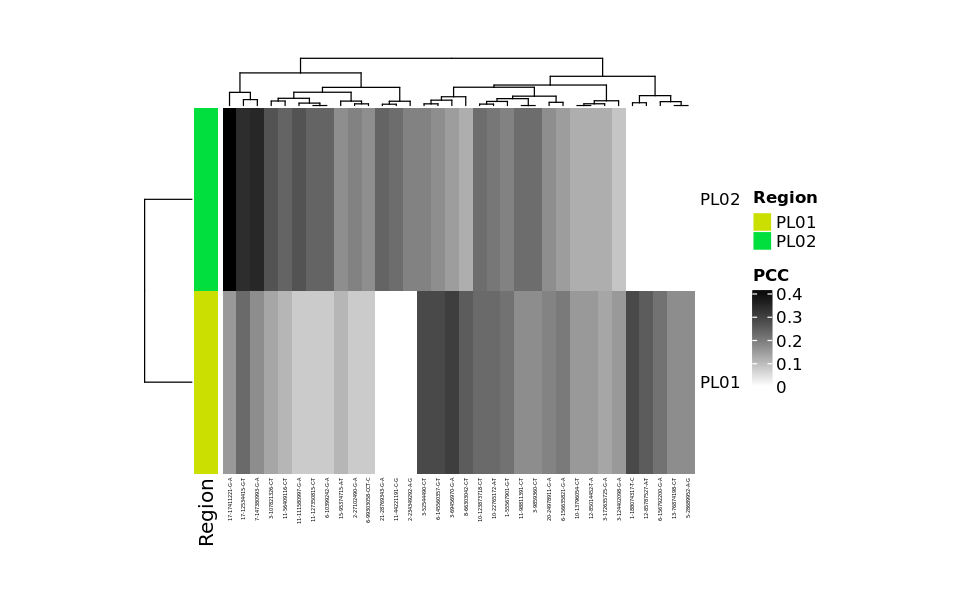

In [294]:
options(repr.plot.width = 8, repr.plot.height = 5)
p<-Heatmap(Normalized_casted_MAF_VarBySample2,
        col = c("white", "black"),
        row_names_gp = gpar(fontsize = "10"), column_names_gp = gpar(fontsize = "3"),
        name = "PCC",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(10, "cm"),
        heatmap_height = unit(10, "cm")) 
p

# Comparison with sorted nuclei data

In [295]:
sort <- read.table("../../20230101_QC/final_summary_anno3.txt",header=T,sep="\t")
sort<-subset(sort, CHROM.POS.REF.ALT %in% filtered$CHROM.POS.REF.ALT &
            Cell_Type %in% c("NeuN") & 
            Hemisphere %in% c("R") &
            Region %in% c("F","T"))

In [296]:
melt_mtcars2<-sort[,c("ID", "MAF", "CHROM.POS.REF.ALT","Cell_Type","Organ",'Region','Punch','Sort_main','Hemisphere')]
melt_mtcars2$MAF <- sqrt(melt_mtcars2$MAF)

In [297]:
melt_mtcars2<-na.omit(melt_mtcars2)

In [298]:
max(melt_mtcars$MAF)

[1] 0.4140393

In [299]:
melt_mtcars3<-rbind((melt_mtcars[,c("CHROM.POS.REF.ALT","Region","MAF")]),
(melt_mtcars2[,c("CHROM.POS.REF.ALT","Region","MAF")]))

In [300]:
casted_MAF_VarBySample <- dcast(melt_mtcars3, Region~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)

In [301]:
rownames(casted_MAF_VarBySample)<-paste0(casted_MAF_VarBySample$Region)

In [302]:
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,]
nrow(casted_MAF_VarBySample2)
unique(casted_MAF_VarBySample2$Region)
unique(casted_MAF_VarBySample2$Cell_Type)

[1] 3

[1] "F"    "PL01" "PL02"

NULL

In [303]:
Normalized_casted_MAF_VarBySample2<-t(na.omit(t(casted_MAF_VarBySample2[,-1])))

In [304]:
casted_MAF_VarBySample2$Region

[1] "F"    "PL01" "PL02"

In [305]:
label<-t(na.omit(t(casted_MAF_VarBySample2[,1])))
label<-as.data.frame(label)
colnames(label)<-c("Region")

In [306]:
left_right_cell_col_ann <- HeatmapAnnotation(simple_anno_size = unit(0.5, "cm"), 
                                             which = "row",
                                             Region = label$Region,
                                             col = list(Region = c("F"="red",
                                                                  "T"="blue",
                                                                   "PL01"="#C663A5",
                                                                   "PL02"="#FFC022"
                                                                 )
                                                       )
                                             )

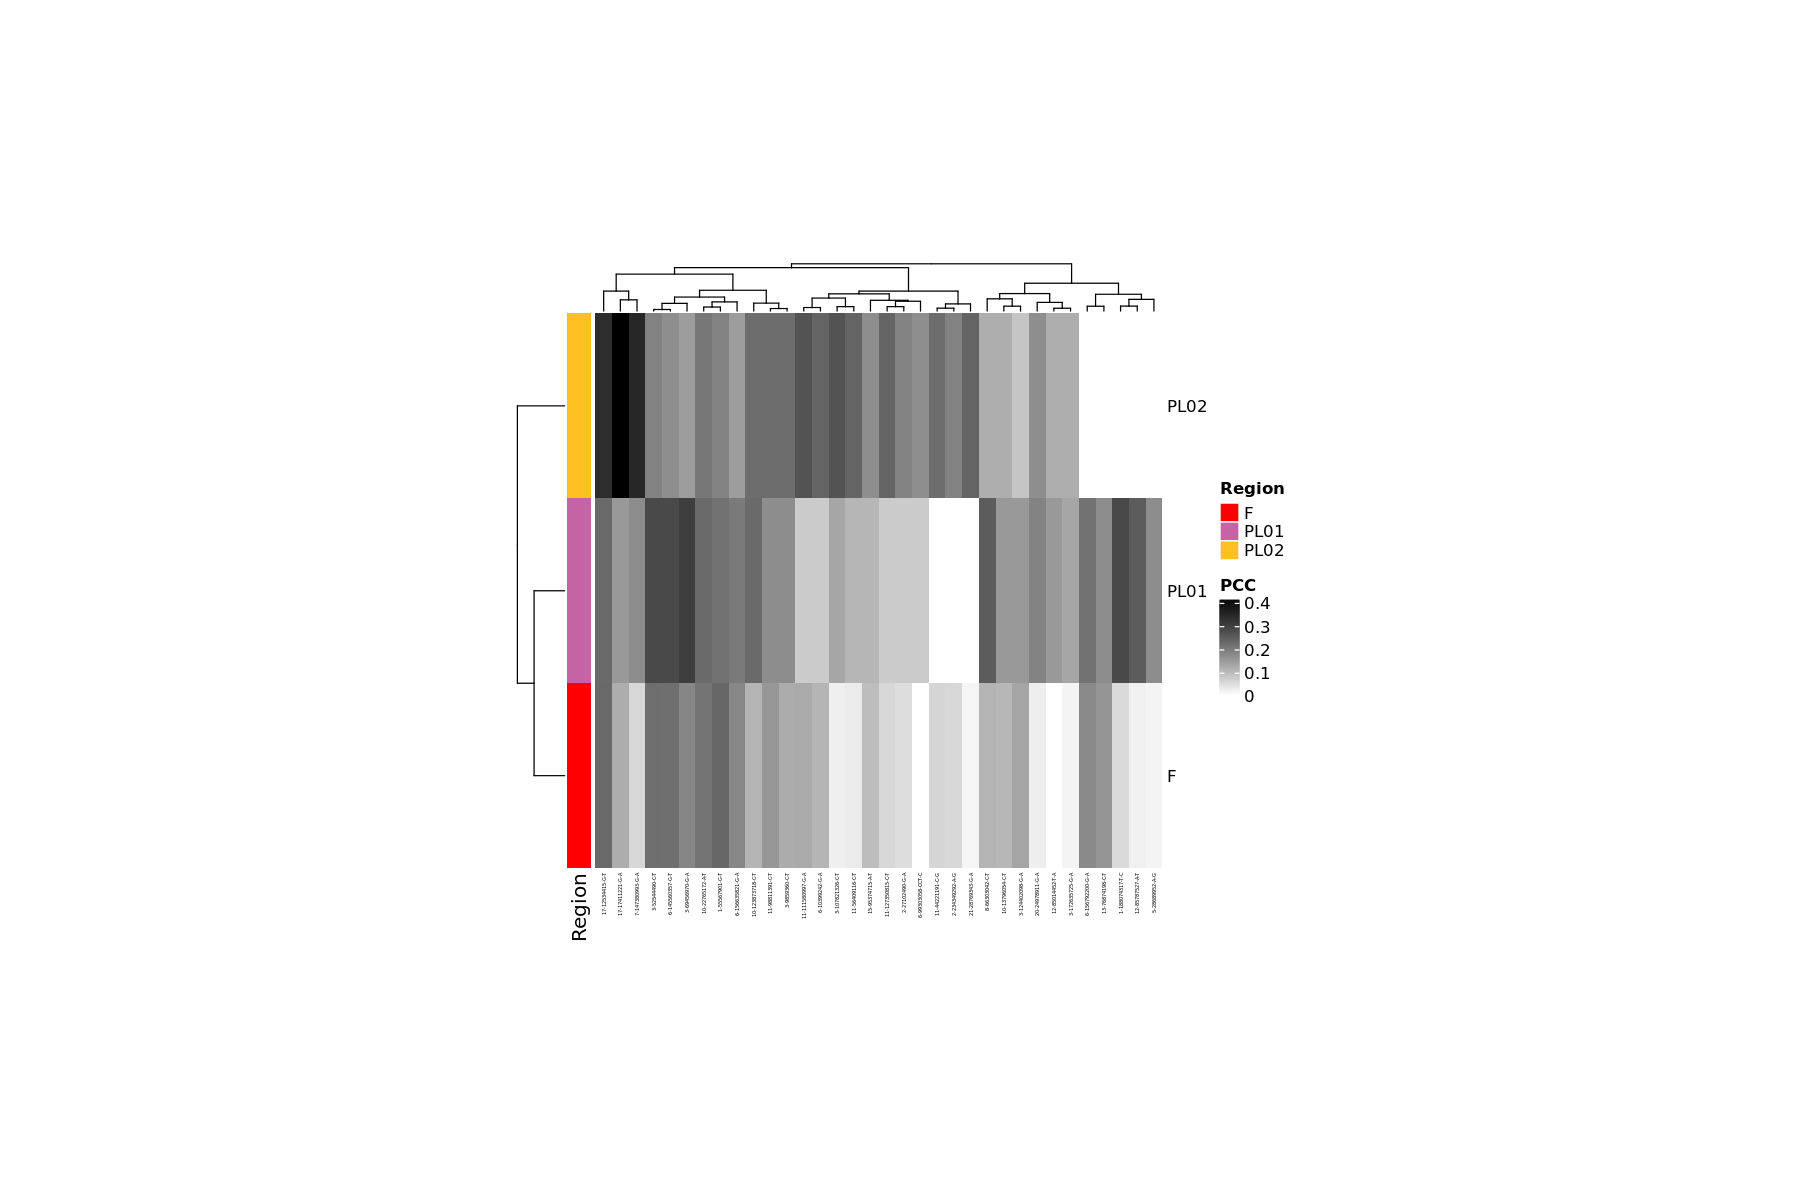

In [330]:
options(repr.plot.width = 15, repr.plot.height = 10)
p<-Heatmap(Normalized_casted_MAF_VarBySample2,
        col = c("white", "black"),
        row_names_gp = gpar(fontsize = "10"), column_names_gp = gpar(fontsize = "3"),
        name = "PCC",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "euclidean", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(12, "cm"),
        heatmap_height = unit(14, "cm")) 
p

In [331]:
pdf(file="ResolveOME_DNA2_4_pseudobulk_with_bulk_comparison_heatmap.pdf",height=10,width=15)
p
dev.off()  

png 
  2

In [308]:
cor<-t(casted_MAF_VarBySample[,-1])
colnames(cor)<-c('F','PL01','PL02')
cor<-(data.frame(cor))
cor

,F,PL01,PL02
,<dbl>,<dbl>,<dbl>
1-188074317-T-C,0.05385148,0.28529870,0.00000000
1-55567901-G-T,0.23329571,0.21566555,0.18898224
10-123873718-C-T,0.11103313,0.22874786,0.22360680
10-13796054-C-T,0.10556236,0.15249857,0.11952286
10-22765172-A-T,0.21221007,0.22874786,0.20701967
11-111580997-G-A,0.12653616,0.07624929,0.26726124
11-127350815-C-T,0.05772948,0.07624929,0.23904572
11-44221191-C-G,0.06052560,0.00000000,0.22360680
11-56409116-C-T,0.02826812,0.10783277,0.23904572


In [332]:
p1<-ggplot(cor, aes(x=F, y=PL01)) + geom_point() + xlim(0,0.4) + ylim(0,0.4)
p2<-ggplot(cor, aes(x=F, y=PL02)) + geom_point() + xlim(0,0.4) + ylim(0,0.4)

Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_poly_eq()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


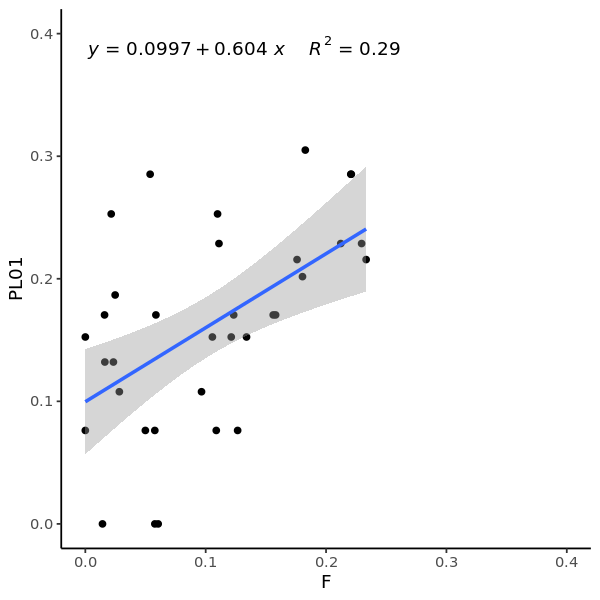

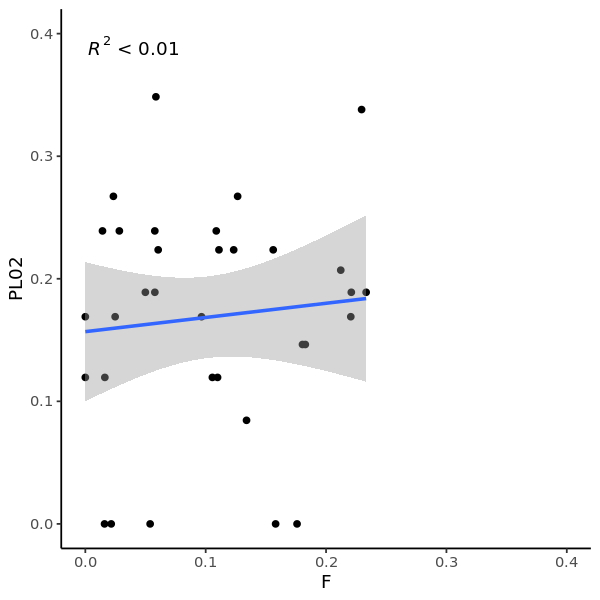

In [333]:
options(repr.plot.width = 5, repr.plot.height = 5)
p1+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm",aes(label = paste(..eq.label.., ..rr.label.., sep = "~~~~")),)+theme_classic() 
p2+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm")+theme_classic()

In [334]:
pdf(file="ResolveOME_DNA2_4_pseudobulk_with_bulk_comparison_correlation1.pdf",height=5,width=5)
p1+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm",aes(label = paste(..eq.label.., ..rr.label.., sep = "~~~~")),)+theme_classic() 
dev.off()
pdf(file="ResolveOME_DNA2_4_pseudobulk_with_bulk_comparison_correlation2.pdf",height=5,width=5)
p2+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm",aes(label = paste(..eq.label.., ..rr.label.., sep = "~~~~")),)+theme_classic() 
dev.off()  

png 
  2

Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_poly_eq()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


png 
  2

In [327]:
cor.test(cor$F,cor$PL01)
cor.test(cor$F,cor$PL02)


	Pearson's product-moment correlation

data:  cor$F and cor$PL01
t = 3.6093, df = 32, p-value = 0.001035
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2441228 0.7412253
sample estimates:
     cor 
0.537884 



	Pearson's product-moment correlation

data:  cor$F and cor$PL02
t = 0.58904, df = 32, p-value = 0.56
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2431124  0.4267862
sample estimates:
      cor 
0.1035678 
